In [14]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from grating import *

In [15]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [16]:
%config IPCompleter.use_jedi = False

In [17]:
fname = 'dataset.npz'
with np.load(fname) as data:
    designs = data['D']
    responses = data['R']
    
n_grating_layers = designs.shape[-1]
n_freqs = responses.shape[-1]
Dtrain, Dtest, Rtrain, Rtest = train_test_split(designs, responses,
                                                test_size=0.1,
                                                random_state=42)
print("Train set contains {} samples".format(Dtrain.shape[0]))
print("Validation set contains {} samples".format(Dtest.shape[0]))

Train set contains 588429 samples
Validation set contains 65381 samples


In [6]:
activation = keras.activations.sigmoid
# Architecture 4
model = keras.Sequential([layers.Input((n_grating_layers,), name='D'),
                          layers.Dense(500, activation=activation, name='F1'),
                          layers.Dense(200, activation=activation, name='F2'),
                          layers.Dense(200, activation=activation, name='F3'),
                          layers.Dense(200, activation=activation, name='F4'),
                          layers.Dense(n_freqs, activation='sigmoid', name='R')],
                         name='ForwardNet')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
F2 (Dense)                   (None, 500)               8000      
_________________________________________________________________
F3 (Dense)                   (None, 200)               100200    
_________________________________________________________________
F4 (Dense)                   (None, 200)               40200     
_________________________________________________________________
F5 (Dense)                   (None, 200)               40200     
_________________________________________________________________
F6 (Dense)                   (None, 200)               40200     
Total params: 228,800
Trainable params: 228,800
Non-trainable params: 0
_________________________________________________________________


In [8]:
def loss(y_true, y_pred):
    return n_freqs * keras.losses.mse(y_true, y_pred)

model.compile(loss=loss, optimizer='adam')

In [ ]:
try:
    initial_epoch = model.history.epoch[-1] + 1
except AttributeError:
    initial_epoch = 0

info = model.fit(Dtrain, Rtrain,
                 batch_size=128, epochs=4000,
                 validation_data=(Dtest, Rtest),
                 validation_freq=5,
                 initial_epoch=initial_epoch)
initial_epoch = model.history.epoch[-1]

In [29]:
epochs = model.history.epoch[-1] + 1
model.save(
    os.path.join('forward_model',
                 'Arch4_Epochs{}_Adam0001_Sigmoid.h5'.format(epochs)))

Text(0.5, 0, 'Epoch')

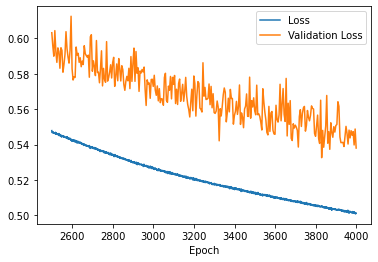

In [31]:
val_loss = model.history.history['val_loss']
loss = model.history.history['loss']
fig, ax = plt.subplots()
ax.plot(info.epoch, loss, label='Loss')
ax.plot(info.epoch[::5], val_loss, label='Validation Loss')
ax.legend()
ax.set_xlabel('Epoch')

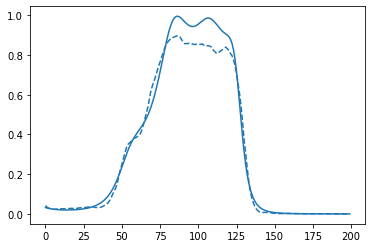

In [49]:
idx = np.random.randint(0, Dtest.shape[0], 1)
dnn_responses = model(Dtest[idx]).numpy()
responses = Rtest[idx]
for o, r in zip(dnn_responses, responses):
    line, = plt.plot(o, '--')
    plt.plot(r, '-', color=line.get_color())

In [18]:
load_dir = 'forward_model'
def loss(y_true, y_pred):
    return n_freqs * keras.losses.mse(y_true, y_pred)

fmodel400 = keras.models.load_model(
    os.path.join(load_dir, 'Arch4_Epochs400_Adam0001_Sigmoid.h5'),
    custom_objects={'loss': loss})
fmodel1000 = keras.models.load_model(
    os.path.join(load_dir, 'Arch4_Epochs1000_Adam0001_Sigmoid.h5'),
    custom_objects={'loss': loss})
fmodel2500 = keras.models.load_model(
    os.path.join(load_dir, 'Arch4_Epochs2500_Adam0001_Sigmoid.h5'),
    custom_objects={'loss': loss})
fmodel4000 = keras.models.load_model(
    os.path.join(load_dir, 'Arch4_Epochs4000_Adam0001_Sigmoid.h5'),
    custom_objects={'loss': loss})

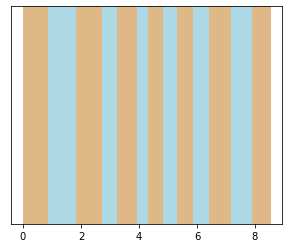

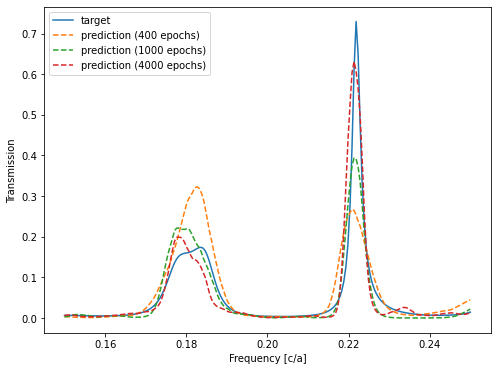

In [22]:
seed = 8
np.random.seed(seed)

epsilon_Si = 13.491
epsilon_SiO2 = 2.085136
n_freqs = 200
freqs = np.linspace(0.15, 0.25, n_freqs)
n_grating_layers = 15

D = np.random.random_sample((1, n_grating_layers))
gr = Grating(epsilon_Si, epsilon_SiO2, D[0])

# plot grating design and save file
gr.plot()
# plt.savefig('grating_seed{}.png'.format(seed), dpi=200)

# plot target and prediction responses and save file
fig, ax = plt.subplots(figsize=(8,6))
line, = ax.plot(freqs, gr.transmittivity(freqs), label='target')
ax.plot(freqs, fmodel400(D)[0].numpy(), '--', label='prediction (400 epochs)')  #color=line.get_color()
ax.plot(freqs, fmodel1000(D)[0].numpy(), '--', label='prediction (1000 epochs)')
# ax.plot(freqs, fmodel2500(D)[0].numpy(), '--', label='prediction (2500 epochs)')
ax.plot(freqs, fmodel4000(D)[0].numpy(), '--', label='prediction (4000 epochs)')
ax.set_xlabel('Frequency [c/a]')
ax.set_ylabel('Transmission')
ax.legend()
# plt.savefig('forward_model_seed{}.png'.format(seed), dpi=200)